In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
import re
from nltk.stem.porter import PorterStemmer
from sklearn.ensemble import StackingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import label_binarize
import pickle

In [3]:
# Step 1: Data pre pro
data = pd.read_csv('combined_output.csv', encoding='ISO-8859-1')


data['text'] = data['text'].astype(str)

port_stem=PorterStemmer()

def steaming(content):
    if isinstance(content, float):
        content = ''
    stemmed_content=re.sub('[^a-zA-Z]',' ',content)
    stemmed_content=stemmed_content.lower()
    stemmed_content=stemmed_content.split()
    stemmed_content=[port_stem.stem(w) for w in stemmed_content if not w in stopwords.words('english')]
    stemmed_content=' '.join(stemmed_content)

    return stemmed_content

data['selected_text']=data['text'].apply(steaming)

# Verify that no NaN values remain
data['selected_text'] = data['selected_text'].fillna('')
data['sentiment'] = data['sentiment'].fillna('')

In [4]:
print(data.head())
# Step 2: Split Data into Training and Test sets
X = data['selected_text']
y = data['sentiment']
print(y.value_counts())
# Convert text data into TF-IDF features
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(X)

# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

                                                text  sentiment  \
0  @switchfoot http://twitpic.com/2y1zl - Awww, t...         -1   
1  is upset that he can't update his Facebook by ...         -1   
2  @Kenichan I dived many times for the ball. Man...         -1   
3    my whole body feels itchy and like its on fire          -1   
4  @nationwideclass no, it's not behaving at all....         -1   

                                       selected_text  
0  switchfoot http twitpic com zl awww bummer sho...  
1  upset updat facebook text might cri result sch...  
2  kenichan dive mani time ball manag save rest g...  
3                    whole bodi feel itchi like fire  
4                      nationwideclass behav mad see  
sentiment
 1    37284
 0    35992
-1    34867
Name: count, dtype: int64


In [12]:
import joblib

# Save the fitted vectorizer to a file
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')

['tfidf_vectorizer.pkl']

In [4]:
# Step 3: Initialize classifiers
svm = SVC(kernel='linear', probability=True)
log_reg = LogisticRegression()
naive_bayes = MultinomialNB()
random_forest = RandomForestClassifier()

In [5]:
# Step 4: Stacking Classifier
stacking_ensemble = StackingClassifier(
    estimators=[
        ('svm', svm),
        ('log_reg', log_reg),
        ('naive_bayes', naive_bayes),
        ('random_forest', random_forest)
    ],
    final_estimator=LogisticRegression()  # The meta-classifier
)

In [33]:
# Step 5: Cross-Validation using StratifiedKFold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cross_val_scores = cross_val_score(stacking_ensemble, X_train, y_train, cv=cv)

print(f"Cross-validated accuracy: {np.mean(cross_val_scores):.4f}")

Cross-validated accuracy: 0.7812


In [ ]:
# Step 6: Train the ensemble model
stacking_ensemble.fit(X_train, y_train)

In [9]:
# Step 7: Make predictions
y_pred = stacking_ensemble.predict(X_test)

In [10]:
# Step 8: Evaluate the model
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8892228027185722
Classification Report:
               precision    recall  f1-score   support

          -1       0.88      0.86      0.87      6914
           0       0.91      0.93      0.92      7179
           1       0.88      0.87      0.87      7536

    accuracy                           0.89     21629
   macro avg       0.89      0.89      0.89     21629
weighted avg       0.89      0.89      0.89     21629



Saving the Model

In [7]:
import pickle
vectorizer = TfidfVectorizer()

In [12]:
# Step 7: Save the trained model to a file using pickle
with open('stacking_ensemble_model.sav', 'wb') as file:
    pickle.dump(stacking_ensemble, file)

In [5]:
with open('stacking_ensemble_model.sav', 'rb') as file:
    loaded_model = pickle.load(file)

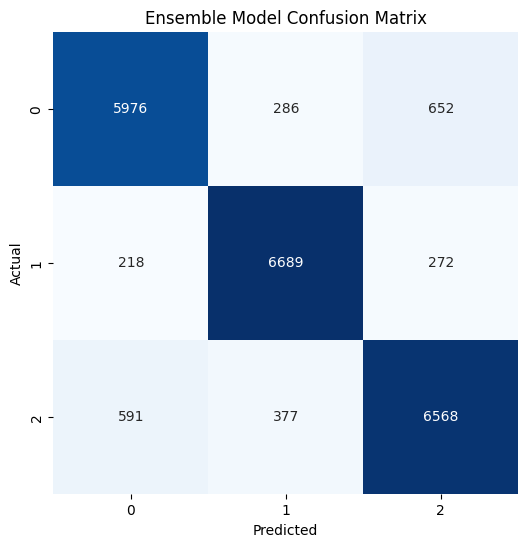

In [8]:
# Make predictions using the loaded ensemble model
y_pred_ensemble = loaded_model.predict(X_test)

# Step 1: Confusion Matrix
plt.figure(figsize=(6, 6))
cm = confusion_matrix(y_test, y_pred_ensemble)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', cbar=False)
plt.title('Ensemble Model Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

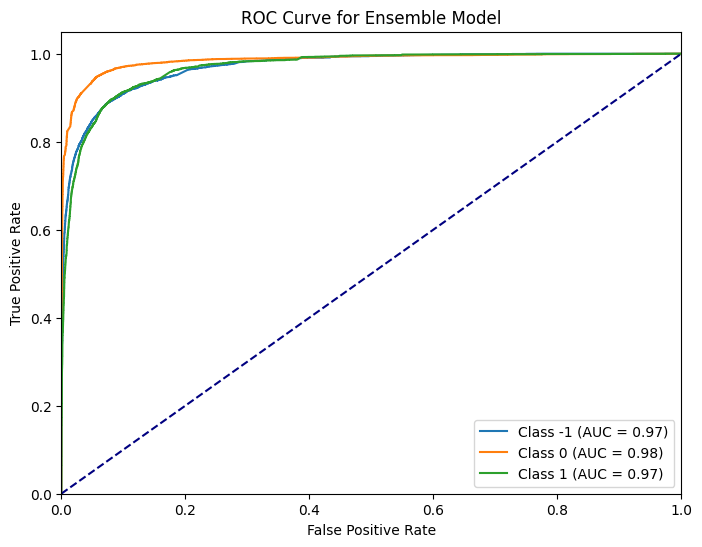

In [10]:
# Step 2: ROC Curve for multi-class classification
# Adjust classes to match your sentiment labels: 1 (positive), 0 (neutral), -1 (negative)
y_bin = label_binarize(y, classes=[-1, 0, 1])  # Negative, Neutral, Positive
n_classes = y_bin.shape[1]

# Decision function for ensemble model
if hasattr(loaded_model, 'decision_function'):  # Some ensemble models like StackingClassifier use decision_function
    y_score_ensemble = loaded_model.decision_function(X_test)
else:
    y_score_ensemble = loaded_model.predict_proba(X_test)

# Plot ROC Curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test == (i-1), y_score_ensemble[:, i])  # Adjust class for sentiment labels
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i-1} (AUC = {roc_auc[i]:.2f})')  # Adjust label in plot

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Ensemble Model')
plt.legend(loc="lower right")
plt.show()

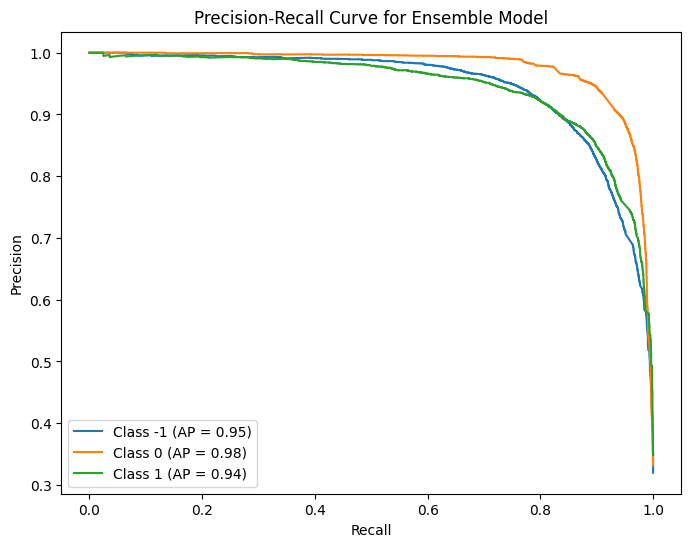

In [11]:
# Step 3: Precision-Recall Curve
precision = dict()
recall = dict()
average_precision = dict()

# Adjust for sentiment labels: -1 (negative), 0 (neutral), 1 (positive)
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test == (i-1), y_score_ensemble[:, i])  # Adjust for class
    average_precision[i] = average_precision_score(y_test == (i-1), y_score_ensemble[:, i])

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(recall[i], precision[i], label=f'Class {i-1} (AP = {average_precision[i]:.2f})')  # Adjust label

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Ensemble Model')
plt.legend(loc="best")
plt.show()

In [ ]:
import numpy as np
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

# Step 4: Feature Importance for the Loaded Stacking Classifier

# Create an empty list to hold feature importances for models that provide it
feature_importance_dict = {}

# Extract feature importance for each base model in the ensemble
for name, estimator in loaded_model.named_estimators_.items():
    model_name = type(estimator).__name__

    # For Random Forest, use feature_importances_
    if hasattr(estimator, 'feature_importances_'):
        feature_importance_dict[model_name] = estimator.feature_importances_

    # For Logistic Regression, use the absolute value of the coefficients
    elif isinstance(estimator, LogisticRegression):
        feature_importance_dict[model_name] = np.abs(estimator.coef_[0])

    # For SVM and Naive Bayes, use permutation importance (with fewer repeats and parallel processing)
    else:
        # Reduce data size for permutation importance to save memory
        sample_size = min(00, X_test.shape[0])  # Use a smaller sample, e.g., 1000 or less
        X_test_sample = X_test[:sample_size].toarray()
        y_test_sample = y_test[:sample_size]

        perm_importance = permutation_importance(
            estimator, X_test_sample, y_test_sample, n_repeats=10, random_state=42, n_jobs=-1
        )
        feature_importance_dict[model_name] = perm_importance.importances_mean


# Averaging feature importance across all base models
avg_importance = np.mean(list(feature_importance_dict.values()), axis=0)

# Get feature names from the vectorizer (used for TF-IDF transformation)
features = vectorizer.get_feature_names_out()

# Sort feature importance in descending order and get top 20 features
sorted_idx = avg_importance.argsort()[::-1][:20]  # Top 20 features
plt.figure(figsize=(10, 6))
plt.barh([features[i] for i in sorted_idx], avg_importance[sorted_idx], color="skyblue")
plt.xlabel('Importance')
plt.title('Top 20 Features in the Loaded Stacking Ensemble Model')
plt.gca().invert_yaxis()
plt.show()

# For the meta-classifier (Logistic Regression), plot its coefficients as feature importance
if hasattr(loaded_model.final_estimator_, 'coef_'):
    meta_feature_importance = np.abs(loaded_model.final_estimator_.coef_[0])

    # Sort feature importance in descending order and get top 20 features
    sorted_idx_meta = meta_feature_importance.argsort()[::-1][:20]  # Top 20 features
    plt.figure(figsize=(10, 6))
    plt.barh([features[i] for i in sorted_idx_meta], meta_feature_importance[sorted_idx_meta], color="orange")
    plt.xlabel('Importance')
    plt.title('Top 20 Features in the Meta-Classifier (Logistic Regression)')
    plt.gca().invert_yaxis()
    plt.show()
else:
    print("Meta-classifier does not support feature importance.")
